In [1]:
import pandas as pd
import geopandas as gpd
from datetime import timedelta
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
DATA_DIR = Path.cwd() / 'data'

color_pal = sns.color_palette('Set1')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

## Explore metadata.csv

In [3]:
metadata = pd.read_csv(DATA_DIR / 'metadata.csv')
metadata

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train
...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test
23566,zzwo,39.792190,-99.971050,2017-06-19,train
23567,zzwq,35.794000,-79.012551,2015-03-24,train
23568,zzyb,35.742000,-79.238600,2016-11-21,train


In [4]:
(metadata['latitude'].astype(str) + ',' + metadata['longitude'].astype(str)).nunique()

12681

In [5]:
metadata['split'].value_counts()

train    17060
test      6510
Name: split, dtype: int64

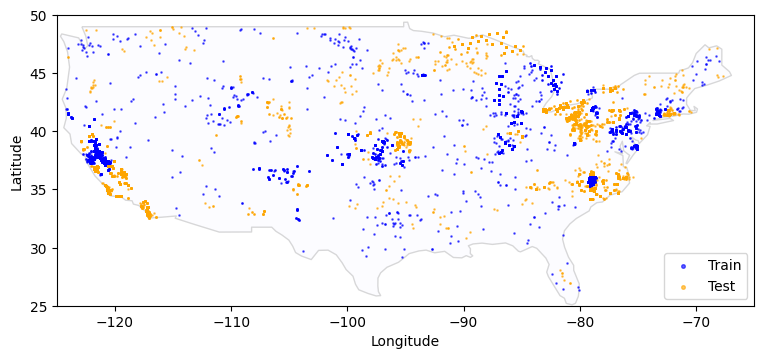

In [6]:
fig, ax = plt.subplots(figsize=(9, 4))

base = world[world.name == "United States of America"].plot(
    edgecolor='gray',
    color='ghostwhite',
    figsize=(9, 4),
    alpha=0.3,
    ax=ax
)

train_metadata = metadata[metadata['split'] == 'train']
geometry = [Point(xy) for xy in zip(train_metadata['longitude'], train_metadata['latitude'])]
gdf = gpd.GeoDataFrame(train_metadata, geometry=geometry)
gdf.plot(
    ax=base,
    marker='.',
    markersize=3,
    color='blue',
    label='Train',
    alpha=0.6
)

test_metadata = metadata[metadata['split'] == 'test']
geometry = [Point(xy) for xy in zip(test_metadata['longitude'], test_metadata['latitude'])]
gdf = gpd.GeoDataFrame(test_metadata, geometry=geometry)
gdf.plot(
    ax=base,
    marker='.',
    markersize=3,
    color='orange',
    label='Test',
    alpha=0.6
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)

In [7]:
metadata.date = pd.to_datetime(metadata.date)

metadata.groupby('split').agg(min_date=('date', 'min'), max_date=('date', 'max'))

,min_date,max_date
split,,
test,2013-01-08,2021-12-29
train,2013-01-04,2021-12-14


<AxesSubplot: title={'center': 'Distribution of years in the data'}, xlabel='Year', ylabel='Number of samples'>

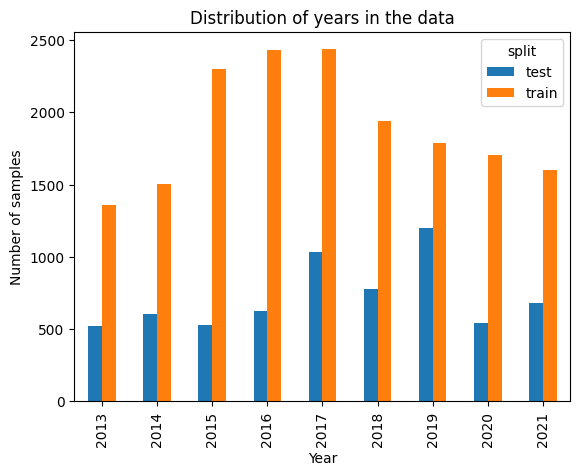

In [8]:
pd.crosstab(metadata.date.dt.year, metadata.split).plot(
    kind='bar',
    ylabel='Number of samples',
    xlabel='Year',
    title='Distribution of years in the data'
)

In [9]:
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
metadata.season.value_counts()

summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

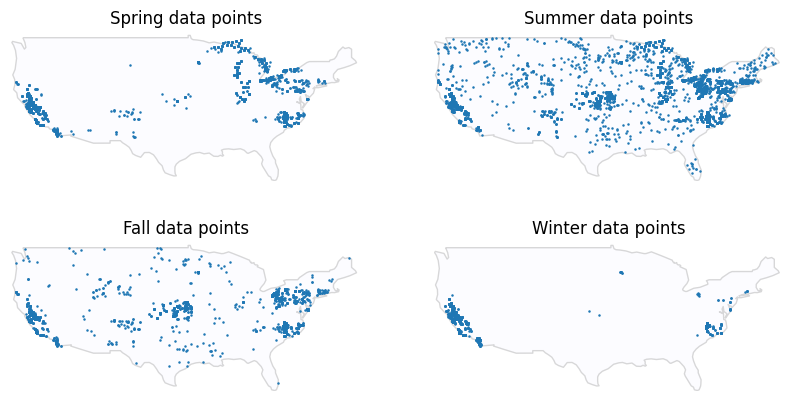

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

for season, ax in zip(metadata.season.unique(), axes.flatten()):
    base = world[world.name == "United States of America"].plot(
        edgecolor='gray',
        color='ghostwhite',
        alpha=0.3,
        ax=ax
    )
    
    sub = metadata[metadata.season == season]
    geometry = [Point(xy) for xy in zip(sub['longitude'], sub['latitude'])]
    gdf = gpd.GeoDataFrame(sub, geometry=geometry)
    gdf.plot(
        ax=base,
        marker='.',
        markersize=2.5
    )
    
    ax.set_xlim([-125, -66])
    ax.set_ylim([25, 50])
    ax.set_title(f"{season.capitalize()} data points")
    ax.axis("off")

## Explore train_labels.csv

In [11]:
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv')
train_labels

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0
...,...,...,...,...
17055,zzsv,south,3,113125.0
17056,zzuq,south,3,175726.0
17057,zzwo,midwest,2,48510.0
17058,zzwq,south,1,1271.0


In [12]:
train_labels.shape

(17060, 4)

In [13]:
train_labels_and_metadata = train_labels.merge(
    metadata,
    how='left',
    left_on='uid',
    right_on='uid',
    validate='1:1'
)

In [14]:
train_labels_and_metadata

,uid,region,severity,density,latitude,longitude,date,split,season
0,aabm,midwest,1,585.0,39.080319,-86.430867,2018-05-14,train,spring
1,aacd,south,1,290.0,35.875083,-78.878434,2020-11-19,train,fall
2,aaee,south,1,1614.0,35.487000,-79.062133,2016-08-24,train,summer
3,aaff,midwest,3,111825.0,38.049471,-99.827001,2019-07-23,train,summer
4,aafl,midwest,4,2017313.0,39.474744,-86.898353,2021-08-23,train,summer
...,...,...,...,...,...,...,...,...,...
17055,zzsv,south,3,113125.0,38.707825,-75.080867,2018-06-27,train,summer
17056,zzuq,south,3,175726.0,35.794000,-79.015368,2015-08-06,train,summer
17057,zzwo,midwest,2,48510.0,39.792190,-99.971050,2017-06-19,train,summer
17058,zzwq,south,1,1271.0,35.794000,-79.012551,2015-03-24,train,spring


Text(0.5, 1.0, 'Train labels severity level counts')

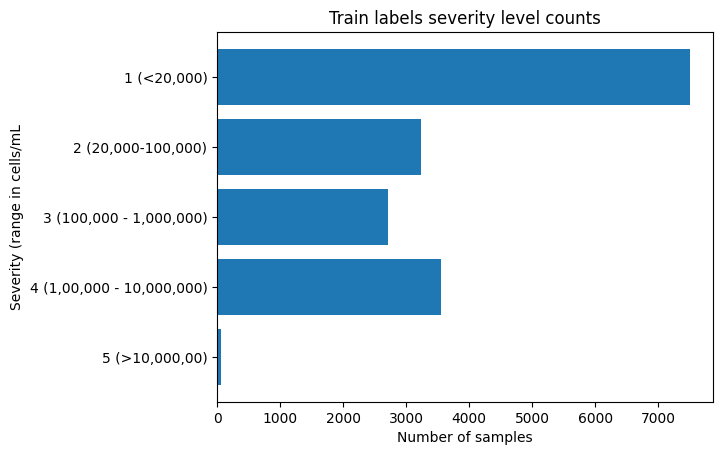

In [15]:
severity_counts = (
    train_labels.replace(
        {
            "severity": {
                1: "1 (<20,000)",
                2: "2 (20,000-100,000)",
                3: "3 (100,000 - 1,000,000)",
                4: "4 (1,00,000 - 10,000,000)",
                5: "5 (>10,000,00)",
            }
        }
    ).severity.value_counts().sort_index(ascending=False)
)

plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL")
plt.title("Train labels severity level counts")

In [16]:
train_labels.density.describe()

count    1.706000e+04
mean     1.074537e+06
std      6.836693e+06
min      0.000000e+00
25%      4.066000e+03
50%      3.270975e+04
75%      4.849192e+05
max      8.046675e+08
Name: density, dtype: float64

In [17]:
(train_labels.density == 0).sum()

91

## Explore submission_format.csv

In [18]:
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='uid')
submission_format

,region,severity
uid,,
aabn,west,1
aair,west,1
aajw,northeast,1
aalr,midwest,1
aalw,west,1
...,...,...
zzpn,northeast,1
zzrv,west,1
zzsx,south,1


In [19]:
submission_format.shape

(6510, 2)

## External Data

##### The general steps we'll use to pull satellite data are:
1. Establish a connection to the Planetary Computer's STAC API using the planetary_computer and pystac_client Python packages.

2. Query the STAC API for scenes that capture our in situ labels. For each sample, we'll search for imagery that includes the sample's location (latitude and longitude) around the date the sample was taken. In this benchmark, we'll use only Sentinel-2 L2A and Landsat Level-2 data.

3. Select one image for each sample. We'll use Sentinel-2 data wherever it is available, because it is higher resolution. We'll have to use Landsat for data before roughly 2016, because Sentinel-2 was not available yet.

4. Convert the image to a 1-dimensional list of features that can be input into our tree model


In [20]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client
import geopy.distance as distance

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [21]:
example_row = metadata[metadata.uid == 'uvat'].iloc[0]
example_row

uid                         uvat
latitude                 37.4312
longitude               -120.995
date         2014-01-14 00:00:00
split                      train
season                    winter
Name: 18889, dtype: object

In [22]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitute, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)
    
    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)   
    min_lat = distance_search.destination(point=(latitute, longitude), bearing=180).latitude
    min_long = distance_search.destination(point=(latitute, longitude), bearing=270).longitude
    max_lat = distance_search.destination(point=(latitute, longitude), bearing=0).latitude
    max_long = distance_search.destination(point=(latitute, longitude), bearing=90).longitude
    
    return [min_long, min_lat, max_long, max_lat]

bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=5000)
bbox


[-121.05149301223803, 37.38614899579297, -120.93850698776198, 37.4762506599975]

In [23]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%d"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


date_range = get_date_range(example_row.date)
date_range

'2013-12-30/2014-01-14'

In [24]:
# search the planetary computer sentinel-l2a and landsat level-2 collections
search = catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"],
    bbox=bbox,
    datetime=date_range,
    query={
        #"eo:cloud_cover": {"lt": 10},
        "platform": {"in": ["Sentinel-2A", "Sentinel-2B", "landsat-8", "landsat-9"]},
    }
)

# see how many items were returned
items = [item for item in search.get_all_items()]
len(items)

2

In [25]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

In [26]:
# check which rows actually contain the sample location
item_details['contains_sample_point'] = (
    (item_details.min_lat < example_row.latitude)
    & (example_row.latitude < item_details.max_lat)
    & (item_details.min_long < example_row.longitude)
    & (example_row.longitude < item_details.max_long)
)

In [27]:
item_details = item_details[item_details['contains_sample_point']]
item_details[['datetime', 'platform', 'contains_sample_point', 'bbox']].sort_values(by='datetime')

,datetime,platform,contains_sample_point,bbox
1,2014-01-06,landsat-8,True,"[-121.89774721, 36.39368486, -119.25368808, 38..."
0,2014-01-13,landsat-8,True,"[-123.42922723, 36.39751485, -120.78987801, 38..."


### Inspect Sentinel Imagery

In [28]:
# 1 - filter to sentinel
item_details[item_details.platform.str.contains('Sentinel')]

,datetime,platform,min_long,max_long,min_lat,max_lat,bbox,item_obj,contains_sample_point


In [234]:
# 2 - take closest by date
best_item = (
    item_details[item_details.platform.str.contains('Sentinel')]
    .sort_values(by='datetime', ascending=False)
    .iloc[0]
)
best_item

datetime                                                        2017-07-29
platform                                                       Sentinel-2A
min_long                                                        -95.504071
max_long                                                        -94.111317
min_lat                                                          43.254722
max_lat                                                          44.247831
bbox                     [-95.50407140709622, 43.254722400220366, -94.1...
item_obj                 <Item id=S2A_MSIL2A_20170729T172111_R112_T15TU...
contains_sample_point                                                 True
Name: 1, dtype: object

In [235]:
item = best_item.item_obj

In [236]:
# What assets are available?
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

In [237]:
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

In [238]:
img = Image(url=item.assets['rendered_preview'].href, width=500)

display(img)

In [239]:
def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

In [240]:
def get_asset(item, asset_key, bbox):
    """
    Given a STAC item and an asset key, return the asset as a numpy array
    """
    (minx, miny, maxx, maxy) = bbox
    
    image = rioxarray.open_rasterio(pc.sign(item.assets[asset_key].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

In [ ]:
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude,
    example_row.longitude,
    meter_buffer=3000
)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_sentinel_image(item, bbox)

zoomed_img_array[0]

In [ ]:
PILImage.fromarray(np.transpose(zoomed_img_array, axes=[1, 2, 0]))

In [88]:
visual = get_asset(item, 'visual', bbox)

In [91]:
b11 = get_asset(item, 'B11', bbox)
b11.shape

(1, 302, 302)

In [68]:
visual = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    ).to_numpy()

In [97]:
item.properties

{'datetime': '2021-09-24T18:11:01.024000Z',
 'platform': 'Sentinel-2A',
 'proj:epsg': 32612,
 'instruments': ['msi'],
 's2:mgrs_tile': '12TWM',
 'constellation': 'Sentinel 2',
 's2:granule_id': 'S2A_OPER_MSI_L2A_TL_ESRI_20210925T141710_A032685_T12TWM_N03.00',
 'eo:cloud_cover': 0.171977,
 's2:datatake_id': 'GS2A_20210924T181101_032685_N03.00',
 's2:product_uri': 'S2A_MSIL2A_20210924T181101_N0300_R084_T12TWM_20210925T141709.SAFE',
 's2:datastrip_id': 'S2A_OPER_MSI_L2A_DS_ESRI_20210925T141710_S20210924T181603_N03.00',
 's2:product_type': 'S2MSI2A',
 'sat:orbit_state': 'descending',
 's2:datatake_type': 'INS-NOBS',
 's2:generation_time': '2021-09-25T14:17:09.626407Z',
 'sat:relative_orbit': 84,
 's2:water_percentage': 0.331475,
 's2:mean_solar_zenith': 44.2224003450655,
 's2:mean_solar_azimuth': 161.724195647543,
 's2:processing_baseline': '03.00',
 's2:snow_ice_percentage': 0.000438,
 's2:vegetation_percentage': 8.349115,
 's2:thin_cirrus_percentage': 0.0,
 's2:cloud_shadow_percentage': 

In [98]:
item.properties['eo:cloud_cover']

0.171977

In [99]:
scl = rioxarray.open_rasterio(pc.sign(item.assets["SCL"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    ).to_numpy()[0]

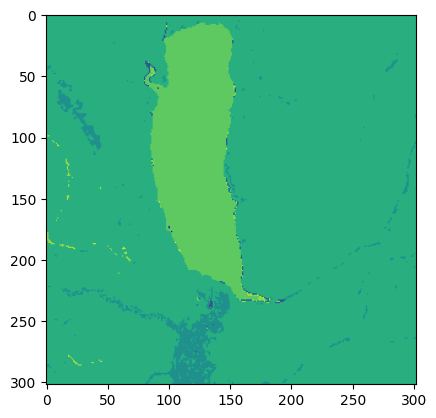

In [100]:
plt.imshow(scl)

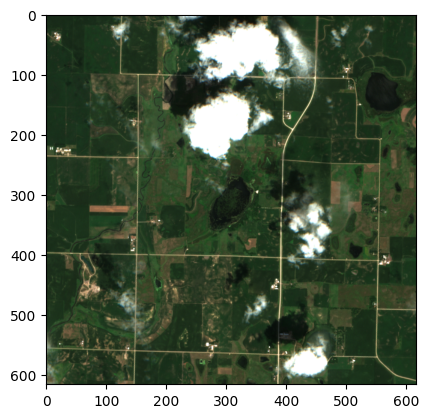

In [242]:
# we have to transpose some of the dimensions to plot
# matplotlib expects channels in a certain order
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2, 0]))

### Inspect Landsat imagery

In [33]:
import odc.stac
import cv2

In [29]:
item_details[item_details.platform.str.contains('|'.join(['landsat-8', 'landsat-9', 'Sentinel']))]

,datetime,platform,min_long,max_long,min_lat,max_lat,bbox,item_obj,contains_sample_point
0,2014-01-13,landsat-8,-123.429227,-120.789878,36.397515,38.525545,"[-123.42922723, 36.39751485, -120.78987801, 38...",<Item id=LC08_L2SP_044034_20140113_02_T1>,True
1,2014-01-06,landsat-8,-121.897747,-119.253688,36.393685,38.534355,"[-121.89774721, 36.39368486, -119.25368808, 38...",<Item id=LC08_L2SP_043034_20140106_02_T1>,True


In [30]:
landsat_item = (
    item_details[item_details.platform.str.contains('landsat-8|landsat-9')]
    #.sample(n=1, random_state=3)
    .iloc[0]
)
landsat_item

datetime                                                        2014-01-13
platform                                                         landsat-8
min_long                                                       -123.429227
max_long                                                       -120.789878
min_lat                                                          36.397515
max_lat                                                          38.525545
bbox                     [-123.42922723, 36.39751485, -120.78987801, 38...
item_obj                         <Item id=LC08_L2SP_044034_20140113_02_T1>
contains_sample_point                                                 True
Name: 0, dtype: object

In [39]:
def crop_landsat_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = odc.stac.stac_load(
        [pc.sign(item)],
        bands=["red", "green", "blue"],
        bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    
    image_array = image[["red", "green", "blue"]].to_array().to_numpy()

    # normalize to 0 - 255 values
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return image_array

In [40]:
item = landsat_item.item_obj


# we'll use the same cropped area as above
landsat_image_array = crop_landsat_image(item, bbox)
landsat_image_array[0]

array([[183, 182, 181, ...,   0,   0,   0],
       [187, 187, 178, ...,   0,   0,   0],
       [156, 179, 186, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

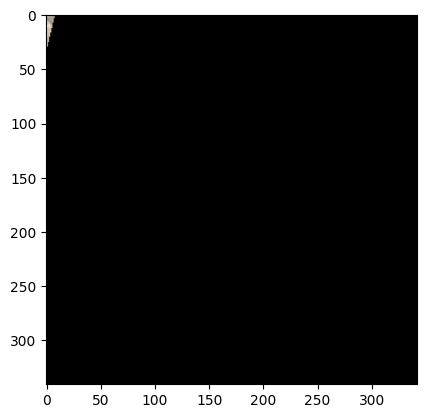

In [41]:
plt.imshow(np.transpose(landsat_image_array, axes=[1, 2, 0]))

### Convert imagery to features

In [246]:
# define a small area to crop around
# crop to 400 meters squared around the sampling point
sminx, sminy, smaxx, smaxy = get_bounding_box(
    example_row.latitude,
    example_row.longitude,
    meter_buffer=500
)
sminx, sminy, smaxx, smaxy

(-95.19763046613113, 43.477989634959584, -95.18526953386888, 43.48699036148455)

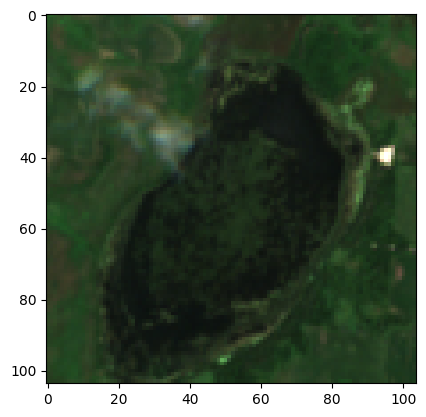

In [247]:
sbbox = (sminx, sminy, smaxx, smaxy)
feature_image_array = crop_sentinel_image(best_item.item_obj, bounding_box=sbbox)
#feature_image_array = crop_landsat_image(landsat_item.item_obj, bounding_box=sbbox)

plt.imshow(np.transpose(feature_image_array, axes=[1, 2, 0]))

In [47]:
type(feature_image_array), feature_image_array.shape

(numpy.ndarray, (3, 21, 21))

In [48]:
# take the average over the second and third dimensions
image_color_averages = feature_image_array.mean(axis=(1, 2)).tolist()

# also take the median
image_color_medians = np.median(feature_image_array, axis=(1, 2)).tolist()

# concatenate the two lists
image_features = image_color_averages + image_color_medians
image_features

[64.1156462585034, 71.21541950113378, 42.44897959183673, 8.0, 26.0, 9.0]

## Refactor and Run

In [49]:
# Refactor our process from above into functions
def select_best_item(items, date, latitude, longitude):
    """
    Select the best satellite item given a sample's date, latitude, and longitude.
    If any Sentinel-2 imagery is available, returns the closest sentinel-2 image by
    time. Otherwise, returns the closest Landsat imagery.

    Returns a tuple of (STAC item, item platform name, item date)
    """
    # get item details
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "item_obj": item,
            }
            for item in items
        ]
    )

    # filter to items that contain the point location, or return None if none contain the point
    item_details["contains_sample_point"] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details["contains_sample_point"] == True]
    
    item_details = item_details[item_details.platform.str.contains('|'.join(['landsat-8', 'landsat-9', 'Sentinel']))]
    
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)

    # add time difference between each item and the sample
    item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
        item_details["datetime"]
    )

    # if we have sentinel-2, filter to sentinel-2 images only
    item_details["sentinel"] = item_details.platform.str.lower().str.contains(
        "sentinel"
    )
    if item_details["sentinel"].any():
        item_details = item_details[item_details["sentinel"] == True]

    # return the closest imagery by time
    best_item = item_details.sort_values(by="time_diff", ascending=True).iloc[0]

    return (best_item["item_obj"], best_item["platform"], best_item["datetime"])

In [50]:
def image_to_features(image_array):
    """
    Convert an image array of the form (color band, height, width) to a
    1-dimensional list of features. Returns a list where the first three
    values are the averages of each color band, and the second three
    values are the medians of each color band.
    """
    averages = image_array.mean(axis=(1, 2)).tolist()
    medians = np.median(image_array, axis=(1, 2)).tolist()

    return averages + medians

In [51]:
BENCHMARK_DATA_DIR = DATA_DIR / "benchmark"

# save image arrays in case we want to generate more features
IMAGE_ARRAY_DIR = BENCHMARK_DATA_DIR / "image_arrays"
IMAGE_ARRAY_DIR.mkdir(exist_ok=True, parents=True)

In [52]:
# take a random subset of the training data for the benchmark
train_subset = metadata[metadata["split"] == "train"].sample(n=2500, random_state=2)

# combine train subset with all test data
metadata_subset = pd.concat([train_subset, metadata[metadata["split"] == "test"]])
metadata_subset.split.value_counts(dropna=False)

test     6510
train    2500
Name: split, dtype: int64

In [53]:
# save outputs in dictionaries
selected_items = {}
features_dict = {}
errored_ids = []

for row in tqdm(metadata_subset.itertuples(), total=len(metadata_subset)):
    pass
    # check if we've already saved the selected image array
    image_array_pth = IMAGE_ARRAY_DIR / f"{row.uid}.npy"

    if image_array_pth.exists():
        with open(image_array_pth, "rb") as f:
            image_array = np.load(f)

        # convert image to 1-dimensional features
        image_features = image_to_features(image_array)
        features_dict[row.uid] = image_features

    # search and load the image array if not
    else:
        try:
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=50000
            )
            date_range = get_date_range(row.date, time_buffer_days=15)

            # search the planetary computer
            search = catalog.search(
                collections=["sentinel-2-l2a", "landsat-c2-l2"],
                bbox=search_bbox,
                datetime=date_range,
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                pass
            else:
                best_item, item_platform, item_date = select_best_item(
                    items, row.date, row.latitude, row.longitude
                )
                # add to dictionary tracking best items
                selected_items[row.uid] = {
                    "item_object": best_item,
                    "item_platform": item_platform,
                    "item_date": item_date,
                }

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=100
            )

            # crop the image
            if "sentinel" in item_platform.lower():
                image_array = crop_sentinel_image(best_item, feature_bbox)
            else:
                image_array = crop_landsat_image(best_item, feature_bbox)

            # save image array so we don't have to rerun
            with open(image_array_pth, "wb") as f:
                np.save(f, image_array)

            # convert image to 1-dimensional features
            image_features = image_to_features(image_array)
            features_dict[row.uid] = image_features

        # keep track of any that ran into errors without interrupting the process
        except:
            errored_ids.append(row.uid)

100%|██████████| 9010/9010 [03:54<00:00, 38.37it/s]  


In [54]:
# see how many ran into errors
print(f"Could not pull satellite imagery for {len(errored_ids)} samples")

Could not pull satellite imagery for 226 samples


In [55]:
# bring features into a dataframe
image_features = pd.DataFrame(features_dict).T
image_features.columns = [
    "red_average",
    "green_average",
    "blue_average",
    "red_median",
    "green_median",
    "blue_median",
]
image_features.head()

,red_average,green_average,blue_average,red_median,green_median,blue_median
umac,26.305195,44.173160,28.357143,25.0,34.0,27.0
egox,59.125000,108.875000,26.718750,22.0,90.5,11.0
havx,68.640625,131.281250,30.859375,55.0,123.0,25.5
laoq,168.375000,206.484375,26.218750,165.0,205.5,25.0
ttsk,24.071429,41.266234,21.489177,23.0,40.0,21.0


In [56]:
# save out our features!
image_features.to_csv(BENCHMARK_DATA_DIR / "image_features.csv", index=True)

In [57]:
# bring features into a dataframe
image_features = pd.DataFrame(features_dict).T
image_features.columns = [
    "red_average",
    "green_average",
    "blue_average",
    "red_median",
    "green_median",
    "blue_median",
]
image_features.head()

,red_average,green_average,blue_average,red_median,green_median,blue_median
umac,26.305195,44.173160,28.357143,25.0,34.0,27.0
egox,59.125000,108.875000,26.718750,22.0,90.5,11.0
havx,68.640625,131.281250,30.859375,55.0,123.0,25.5
laoq,168.375000,206.484375,26.218750,165.0,205.5,25.0
ttsk,24.071429,41.266234,21.489177,23.0,40.0,21.0


In [58]:
# save out our features!
image_features.to_csv(BENCHMARK_DATA_DIR / "image_features.csv", index=True)

## Build GBM Model

In [59]:
# bring together train labels and features into one dataframe
# this ensures the features array and labels array will be in same order
train_data = train_labels.merge(
    image_features, how="inner", left_on="uid", right_index=True, validate="1:1"
)

# split into train and validation
rng = np.random.RandomState(30)
train_data["split"] = rng.choice(
    ["train", "validation"], size=len(train_data), replace=True, p=[0.67, 0.33]
)

train_data.head()

,uid,region,severity,density,red_average,green_average,blue_average,red_median,green_median,blue_median,split
4,aafl,midwest,4,2.017313e+06,95.807256,102.832200,74.993197,53.0,71.0,46.0,train
5,aafp,south,1,1.594000e+03,18.410431,25.294785,12.448980,18.0,24.0,12.0,train
20,aarq,northeast,1,1.013300e+04,45.984127,37.170068,15.392290,27.0,27.0,8.0,train
31,aben,south,1,9.730000e+03,127.000000,151.041126,147.158009,105.0,128.0,116.0,train
37,aboc,midwest,1,3.582413e+02,255.000000,255.000000,255.000000,255.0,255.0,255.0,validation


In [60]:
# separate features and labels, and train and validation
feature_cols = [
    "red_average",
    "green_average",
    "blue_average",
    "red_median",
    "green_median",
    "blue_median",
]
target_col = "severity"

val_set_mask = train_data.split == "validation"
X_train = train_data.loc[~val_set_mask, feature_cols].values
y_train = train_data.loc[~val_set_mask, target_col]
X_val = train_data.loc[val_set_mask, feature_cols].values
y_val = train_data.loc[val_set_mask, target_col]

# flatten label data into 1-d arrays
y_train = y_train.values.flatten()
y_val = y_val.values.flatten()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1604, 6), (846, 6), (1604,), (846,))

In [61]:
# see an example of what the data looks like
print("X_train[0]:", X_train[0])
print("y_train[:10]:", y_train[:10])

X_train[0]: [ 95.80725624 102.83219955  74.99319728  53.          71.
  46.        ]
y_train[:10]: [4 1 1 1 4 1 5 3 1 1]


In [62]:
# save out features
x_train_pth = BENCHMARK_DATA_DIR / "x_train.npy"
x_train_pth.parent.mkdir(exist_ok=True, parents=True)

with open(x_train_pth, "wb") as f:
    np.save(f, X_train)

# save out labels
y_train_pth = BENCHMARK_DATA_DIR / "y_train.npy"

with open(y_train_pth, "wb") as f:
    np.save(f, y_train)

In [63]:
%%writefile train_gbm_model.py
import lightgbm as lgb

import joblib
import numpy as np
from pathlib import Path
from loguru import logger
import typer

DATA_DIR = Path.cwd() / "data/benchmark"


def main(
    features_path=DATA_DIR / "x_train.npy",
    labels_path=DATA_DIR / "y_train.npy",
    model_save_path=DATA_DIR / "lgb_classifier.txt",
):
    """
    Train a LightGBM model based on training features in features_path and
    training labels in labels_path. Save our the trained model to model_save_path
    """

    # load saved features and labels
    with open(features_path, "rb") as f:
        X_train = np.load(f)
    with open(labels_path, "rb") as f:
        y_train = np.load(f)

    logger.info(f"Loaded training features of shape {X_train.shape} from {features_path}")
    logger.info(f"Loading training labels of shape {y_train.shape} from {labels_path}")

    # instantiate tree model
    model = lgb.LGBMClassifier(random_state=10)

    # fit model
    logger.info("Fitting LGBM model")
    model.fit(X_train, y_train)
    print(model)

    # save out model weights
    joblib.dump(model, str(model_save_path))
    logger.success(f"Model weights saved to {model_save_path}")


if __name__ == "__main__":
    typer.run(main)

Overwriting train_gbm_model.py


In [64]:
!python train_gbm_model.py

LGBMClassifier(random_state=10)


2023-02-10 17:46:35.683 | INFO     | __main__:main:28 - Loaded training features of shape (1604, 6) from c:\Users\Keenan Samway\Documents\GitHub\Algal-Bloom-Detection\data\benchmark\x_train.npy
2023-02-10 17:46:35.683 | INFO     | __main__:main:29 - Loading training labels of shape (1604,) from c:\Users\Keenan Samway\Documents\GitHub\Algal-Bloom-Detection\data\benchmark\y_train.npy
2023-02-10 17:46:35.683 | INFO     | __main__:main:35 - Fitting LGBM model
2023-02-10 17:46:36.016 | SUCCESS  | __main__:main:41 - Model weights saved to c:\Users\Keenan Samway\Documents\GitHub\Algal-Bloom-Detection\data\benchmark\lgb_classifier.txt


In [65]:
# save out validation features
x_val_pth = BENCHMARK_DATA_DIR / "x_val.npy"
x_val_pth.parent.mkdir(exist_ok=True, parents=True)

with open(x_val_pth, "wb") as f:
    np.save(f, X_val)

# save out validation labels
y_val_pth = BENCHMARK_DATA_DIR / "y_val.npy"

with open(y_val_pth, "wb") as f:
    np.save(f, y_val)

In [66]:
%%writefile predict_gbm_model.py
import lightgbm as lgb

import joblib
from loguru import logger
import numpy as np
from pathlib import Path
import typer

DATA_DIR = Path.cwd() / "data/benchmark"


def main(
    model_weights_path=DATA_DIR / "lgb_classifier.txt",
    features_path=DATA_DIR / "x_val.npy",
    preds_save_path=DATA_DIR / "val_preds.npy",
):
    """
    Generate predictions with a LightGBM model using weights saved at model_weights_path
    and features saved at features_path. Save out predictions to preds_save_path.
    """
    # load model weights
    lgb_model = joblib.load(model_weights_path)
    logger.info(f"Loaded model {lgb_model} from {model_weights_path}")

    # load the features
    with open(features_path, "rb") as f:
        X_val = np.load(f)
    logger.info(f"Loaded features of shape {X_val.shape} from {features_path}")

    # generate predictions
    preds = lgb_model.predict(X_val)

    # save out predictions
    with open(preds_save_path, "wb") as f:
        np.save(f, preds)
    logger.success(f"Predictions saved to {preds_save_path}")


if __name__ == "__main__":
    typer.run(main)

Overwriting predict_gbm_model.py


In [67]:
!python predict_gbm_model.py

2023-02-10 17:46:45.009 | INFO     | __main__:main:23 - Loaded model LGBMClassifier(random_state=10) from c:\Users\Keenan Samway\Documents\GitHub\Algal-Bloom-Detection\data\benchmark\lgb_classifier.txt
2023-02-10 17:46:45.016 | INFO     | __main__:main:28 - Loaded features of shape (846, 6) from c:\Users\Keenan Samway\Documents\GitHub\Algal-Bloom-Detection\data\benchmark\x_val.npy
2023-02-10 17:46:45.019 | SUCCESS  | __main__:main:36 - Predictions saved to c:\Users\Keenan Samway\Documents\GitHub\Algal-Bloom-Detection\data\benchmark\val_preds.npy


## Evaluate Performance

In [68]:
preds_pth = BENCHMARK_DATA_DIR / "val_preds.npy"
with open(preds_pth, "rb") as f:
    val_preds = np.load(f)

In [69]:
val_preds[:10]

array([1, 1, 2, 1, 1, 1, 1, 1, 4, 1], dtype=int64)

In [70]:
pd.Series(val_preds).value_counts().sort_index()

1    607
2     80
3     61
4     98
dtype: int64

In [71]:
# get the validation part of the training data
val_set = train_data[train_data.split == "validation"][
    ["uid", "region", "severity"]
].copy()
val_set["pred"] = val_preds

val_set.head()

,uid,region,severity,pred
37,aboc,midwest,1,1
42,abso,south,2,1
91,aduy,south,2,2
94,adwl,south,1,1
120,afbi,midwest,4,1


In [72]:
region_scores = []
for region in val_set.region.unique():
    sub = val_set[val_set.region == region]
    region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
    print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
    region_scores.append(region_rmse)

overall_rmse = np.mean(region_scores)
print(f"Final score: {overall_rmse}")

RMSE for midwest (n=99): 1.6112
RMSE for south (n=498): 1.104
RMSE for west (n=200): 2.0384
RMSE for northeast (n=49): 1.2372
Final score: 1.4976964984507677


In [73]:
# what's our RMSE across all validation data points?
mean_squared_error(y_val, val_preds, squared=False)

1.446443424942809

In [74]:
# how many times did each severity level show up in our predictions vs. the actual values?
val_results = pd.DataFrame({"pred": val_preds, "actual": y_val})

pd.concat(
    [
        val_results.pred.value_counts().sort_index().rename("predicted"),
        val_results.actual.value_counts().sort_index().rename("actual"),
    ],
    axis=1,
).rename_axis("severity_level_count")

,predicted,actual
severity_level_count,,
1,607.0,356
2,80.0,172
3,61.0,136
4,98.0,178
5,NaN,4


In [75]:
image_features

,red_average,green_average,blue_average,red_median,green_median,blue_median
umac,26.305195,44.173160,28.357143,25.0,34.0,27.0
egox,59.125000,108.875000,26.718750,22.0,90.5,11.0
havx,68.640625,131.281250,30.859375,55.0,123.0,25.5
laoq,168.375000,206.484375,26.218750,165.0,205.5,25.0
ttsk,24.071429,41.266234,21.489177,23.0,40.0,21.0
...,...,...,...,...,...,...
zzpn,42.372294,67.093074,55.326840,36.0,63.0,52.0
zzrv,106.716450,77.885281,51.517316,90.0,71.0,46.0
zzsx,44.778926,49.993802,43.316116,40.0,45.0,40.0
zzvv,82.703125,87.343750,158.406250,79.5,82.0,158.5


In [76]:
# get the image features for the test set
test_features = submission_format.join(image_features, how="left", validate="1:1")

# make sure our features are in the same order as the submission format
assert (test_features.index == submission_format.index).all()

test_features

,region,severity,red_average,green_average,blue_average,red_median,green_median,blue_median
uid,,,,,,,,
aabn,west,1,0.000000,0.000000,0.000000,0.0,0.0,0.0
aair,west,1,156.718750,141.578125,143.578125,159.5,146.5,146.5
aajw,northeast,1,111.795918,121.775510,62.000000,97.0,116.0,50.0
aalr,midwest,1,255.000000,255.000000,255.000000,255.0,255.0,255.0
aalw,west,1,127.997732,105.900227,84.965986,128.0,93.0,72.0
...,...,...,...,...,...,...,...,...
zzpn,northeast,1,42.372294,67.093074,55.326840,36.0,63.0,52.0
zzrv,west,1,106.716450,77.885281,51.517316,90.0,71.0,46.0
zzsx,south,1,44.778926,49.993802,43.316116,40.0,45.0,40.0


In [77]:
test_features.isna().sum()

region             0
severity           0
red_average      176
green_average    176
blue_average     176
red_median       176
green_median     176
blue_median      176
dtype: int64

In [78]:
# fill in missing values
for avg_col in ["red_average", "green_average", "blue_average"]:
    test_features[avg_col] = test_features[avg_col].fillna(
        test_features[avg_col].mean()
    )
for median_col in ["red_median", "green_median", "blue_median"]:
    test_features[median_col] = test_features[median_col].fillna(
        test_features[median_col].median()
    )

In [79]:
# select feature columns
feature_cols = [
    "red_average",
    "green_average",
    "blue_average",
    "red_median",
    "green_median",
    "blue_median",
]

X_test = test_features[feature_cols].values

print(X_test.shape)

X_test[1]

(6510, 6)


array([156.71875 , 141.578125, 143.578125, 159.5     , 146.5     ,
       146.5     ])

In [80]:
# save out test features
x_test_pth = BENCHMARK_DATA_DIR / "x_test.npy"
with open(x_test_pth, "wb") as f:
    np.save(f, X_test)

In [81]:
test_preds_pth = BENCHMARK_DATA_DIR / "test_preds.npy"

In [91]:
!python predict_gbm_model.py --features-path {x_test_pth.relative_to(Path.cwd())} --preds-save-path {test_preds_pth.relative_to(Path.cwd())}

2023-02-10 17:52:24.505 | INFO     | __main__:main:23 - Loaded model LGBMClassifier(random_state=10) from c:\Users\Keenan Samway\Documents\GitHub\Algal-Bloom-Detection\data\benchmark\lgb_classifier.txt
2023-02-10 17:52:24.514 | INFO     | __main__:main:28 - Loaded features of shape (6510, 6) from data\benchmark\x_test.npy
2023-02-10 17:52:24.532 | SUCCESS  | __main__:main:36 - Predictions saved to data\benchmark\test_preds.npy


In [92]:
# load our predictions
with open(test_preds_pth, "rb") as f:
    test_preds = np.load(f)

In [93]:
submission = submission_format.copy()
submission["severity"] = test_preds

submission.head()

,region,severity
uid,,
aabn,west,1
aair,west,3
aajw,northeast,4
aalr,midwest,1
aalw,west,4


In [94]:
# save out our formatted submission
submission_save_path = BENCHMARK_DATA_DIR / "submission.csv"
submission.to_csv(submission_save_path, index=True)

In [96]:
# make sure our saved csv looks correct
!cat {submission_save_path} | head -5

'head' is not recognized as an internal or external command,
operable program or batch file.
